# Predicting Car Prices  Using Linear Regression  

The following notebook provides an example code of linear regression analysis, using car prices dataset.  
The goal is to understand what features influence the price of the listed cars. 

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # t-tests
import statsmodels.api as sm
from statsmodels.api import qqplot
from statsmodels.stats.diagnostic import het_breuschpagan,linear_rainbow  #variance equality and linearity tests
from scipy.stats import shapiro #for normality checks

# Disable jedi autocompleter
%config Completer.use_jedi = False

In [2]:
# set notebook environment

%precision %.3f
pd.options.display.float_format = '{:,.2f}'.format
sns.set(context='paper', style='darkgrid')
plt.rcParams["figure.figsize"] = 10,8
pd.set_option('display.width', 100)
#plt.rcParams.update({'font.size': 14})


## 1. Descriptive Analysis

In [3]:
cars = pd.read_csv('data/car_data.csv')
cars.sample(3)

,make,fuel_type,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
136,subaru,gas,four,wagon,4wd,front,96.90,173.60,65.40,54.90,...,108,2bbl,3.62,2.64,9.00,82,4800,23,29,8013
131,subaru,gas,four,sedan,fwd,front,97.20,172.00,65.40,52.50,...,108,mpfi,3.62,2.64,9.00,94,5200,26,32,9960
54,mazda,gas,four,sedan,fwd,front,98.80,177.80,66.50,55.50,...,122,2bbl,3.39,3.39,8.60,84,4800,26,32,10245


In [4]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               193 non-null    object 
 1   fuel_type          193 non-null    object 
 2   num_of_doors       193 non-null    object 
 3   body_style         193 non-null    object 
 4   drive_wheels       193 non-null    object 
 5   engine_location    193 non-null    object 
 6   wheel_base         193 non-null    float64
 7   length             193 non-null    float64
 8   width              193 non-null    float64
 9   height             193 non-null    float64
 10  curb_weight        193 non-null    int64  
 11  engine_type        193 non-null    object 
 12  num_of_cylinders   193 non-null    object 
 13  engine_size        193 non-null    int64  
 14  fuel_system        193 non-null    object 
 15  bore               193 non-null    float64
 16  stroke             193 non

In [5]:
cars.nunique()

make                  21
fuel_type              2
num_of_doors           2
body_style             5
drive_wheels           3
engine_location        2
wheel_base            50
length                71
width                 41
height                46
curb_weight          165
engine_type            5
num_of_cylinders       6
engine_size           40
fuel_system            7
bore                  38
stroke                36
compression_ratio     31
horsepower            56
peak_rpm              21
city_mpg              28
highway_mpg           30
price                178
dtype: int64

A good practice is to change the object variables to categorical ones. It will save you a lot of memory space. Since our data set is not that big, we can skeep this step.

In [6]:
# prices in 5 number stats
cars['price'].describe()

count      193.00
mean    13,285.03
std      8,089.08
min      5,118.00
25%      7,738.00
50%     10,245.00
75%     16,515.00
max     45,400.00
Name: price, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Count'>

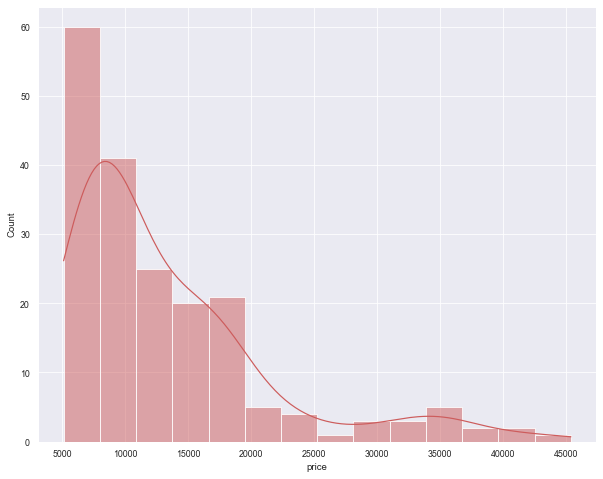

In [7]:
sns.histplot(data=cars, x='price', kde=True, color='indianred')

Let's first start by looking at the relationship between the price and the features with a float data type:

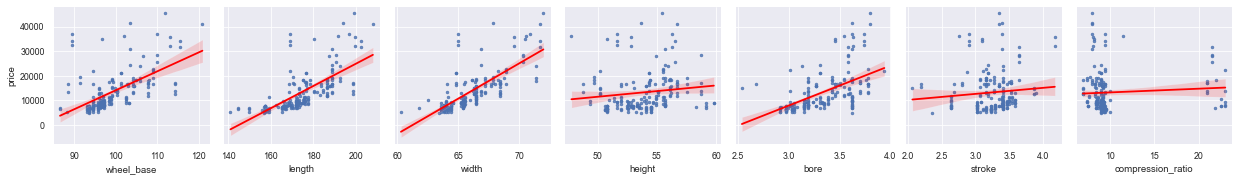

In [8]:
vars = cars.select_dtypes(include='float64').columns
sns.pairplot(data=cars, x_vars= vars, y_vars='price', kind='reg', 
             plot_kws={'line_kws':{'color':'red'}, 'scatter_kws':{'s': 6}});

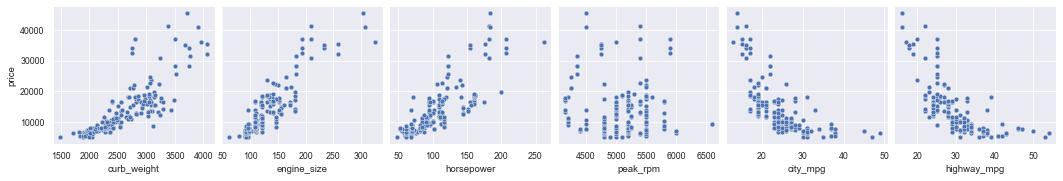

In [9]:
# features with int dtype
vars = cars.iloc[:, :-1].select_dtypes(include='int').columns
sns.pairplot(data=cars, x_vars= vars, y_vars='price');

/Users/athena/opt/miniconda3/envs/mlpocref/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


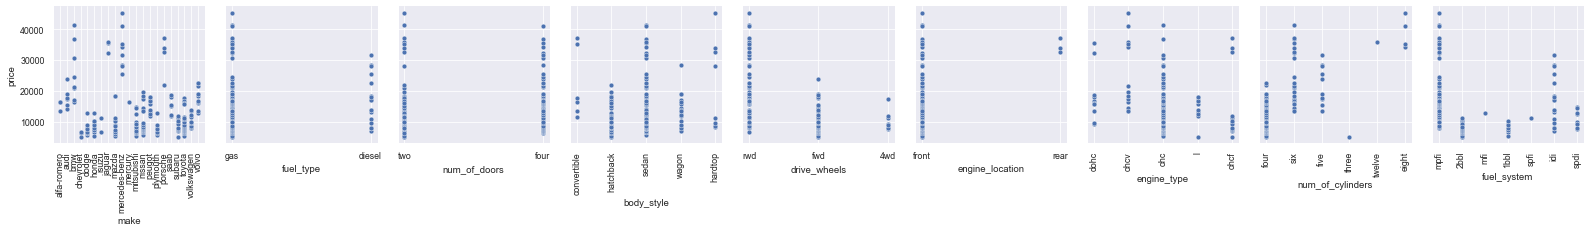

In [10]:
# object variables 
# features with int dtype
vars = cars.iloc[:, :-1].select_dtypes(include='object').columns
g = sns.pairplot(data=cars, x_vars= vars, y_vars='price')
for ax in g.axes.flatten():
    # rotate x axis labels
    if len(ax.get_xticklabels()) > 4:
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


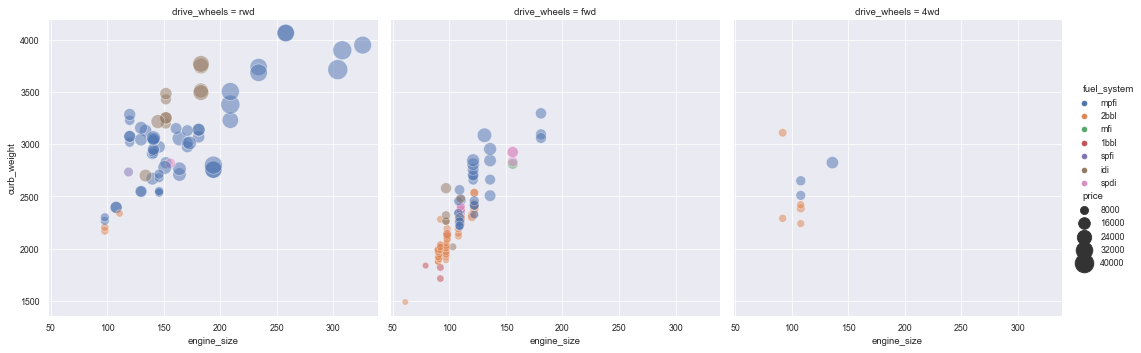

In [11]:
g = sns.relplot(data=cars, x='engine_size', y='curb_weight', kind='scatter', 
                size='price', sizes=(40, 400), alpha=.5, hue='fuel_system',
               col='drive_wheels')

In the above figure we included the price in the size of the dots, which is also very handy when we want to visualize more complex relationships between more than one feature and the dependent variable.

## 2. Confirmatory Analysis Using Statistical Tests

Let's see if the average price differs by the number of doors

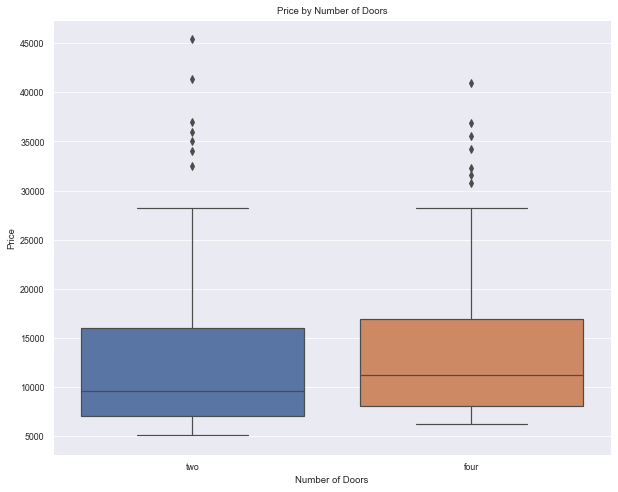

In [12]:
g = sns.boxplot(data=cars, x='num_of_doors', y='price')
g.set(xlabel='Number of Doors', ylabel='Price', title='Price by Number of Doors');

We can see from the diagram above that there is a marginal difference between the prices of two- and four-door cars. To find out whether the difference is statistically significant, we use the t-test.

T-test is used to determine whether the means of two groups are equal to each other. the null hypothesis ($H_0$) is that the two means are equal, and the alternative hypothesis ($H_A$) is that they are not.  

We reject $H_0$ at a chosen level of statistical significance (or confidence). A statistical text may return a value called the *p-value*. This is a quantity that we can use to interpret or quantify the result of the t-test and either *reject* or *fail to reject* the null hypothesis.  

This is done by comparing the *p-value* to a predefined threshold value $\alpha$ between $5\%$ and $0.1\%$:

* if p-value $\leq$ alpha: reject null hypothesis
* if p-value > alpha: not a significant result. Fail to reject the null hypothesis


In [13]:
stats.ttest_ind(cars['price'][cars['num_of_doors'] == 'two'],
                cars['price'][cars['num_of_doors'] == 'four'])

Ttest_indResult(statistic=-0.6427899222652471, pvalue=0.521131300440071)

the pvalue is much bigger than alpha = 0.05. It is a statistically insignificant result and so it fails to reject the null hypothesis.

### 2.1 Checking for Correlations (Multicolinearity)

The `corr()` method computes pairwise correlation of columns and automatically excludes object dtype variables as well as `Nan`'s.

In [14]:
cars.corr()

,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
wheel_base,1.00,0.88,0.82,0.59,0.78,0.57,0.50,0.17,0.25,0.38,-0.35,-0.50,-0.57,0.58
length,0.88,1.00,0.86,0.49,0.88,0.69,0.61,0.12,0.16,0.59,-0.28,-0.70,-0.73,0.70
width,0.82,0.86,1.00,0.31,0.87,0.74,0.54,0.19,0.19,0.62,-0.25,-0.66,-0.70,0.75
height,0.59,0.49,0.31,1.00,0.31,0.03,0.18,-0.05,0.25,-0.08,-0.26,-0.11,-0.16,0.14
curb_weight,0.78,0.88,0.87,0.31,1.00,0.86,0.65,0.18,0.16,0.76,-0.28,-0.78,-0.82,0.84
engine_size,0.57,0.69,0.74,0.03,0.86,1.00,0.58,0.21,0.03,0.85,-0.22,-0.72,-0.74,0.89
bore,0.50,0.61,0.54,0.18,0.65,0.58,1.00,-0.07,-0.00,0.57,-0.27,-0.60,-0.61,0.55
stroke,0.17,0.12,0.19,-0.05,0.18,0.21,-0.07,1.00,0.20,0.10,-0.07,-0.03,-0.04,0.10
compression_ratio,0.25,0.16,0.19,0.25,0.16,0.03,-0.00,0.20,1.00,-0.20,-0.44,0.31,0.25,0.07
horsepower,0.38,0.59,0.62,-0.08,0.76,0.85,0.57,0.10,-0.20,1.00,0.10,-0.83,-0.81,0.81


It is better visualized when using a heatmap:

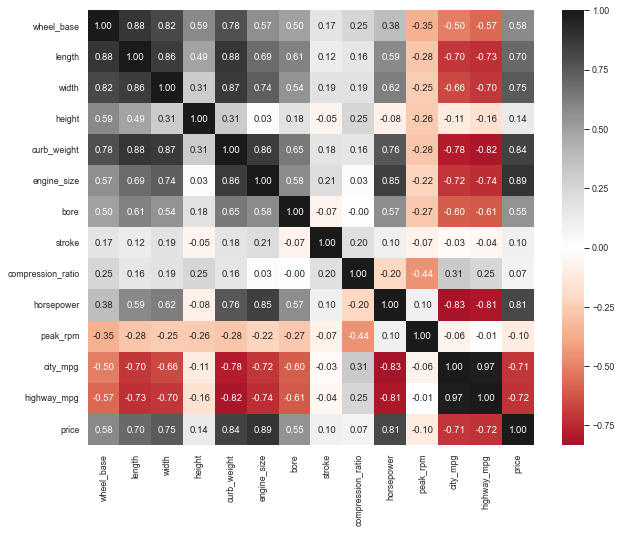

In [15]:
# Diverging colormaps are best for heatmaps if you want to see negative and positive correlations
sns.heatmap(cars.corr(), annot=True, cmap='RdGy', center=0.0,  fmt='.2f');

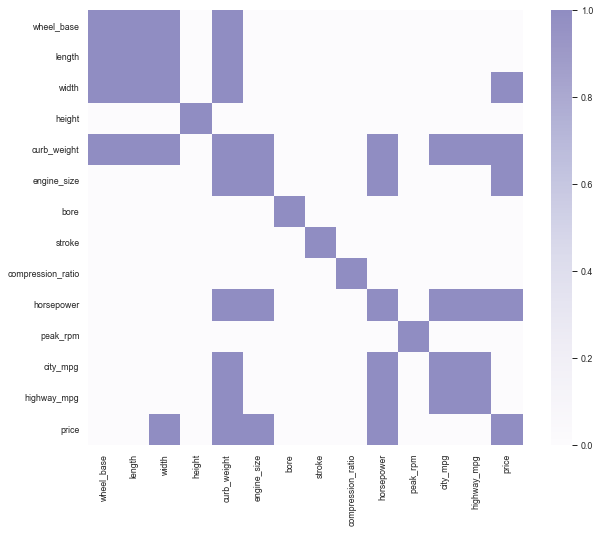

In [16]:
# If you are only interested in correaltion:
sns.heatmap(cars.corr().abs()>.74, cmap='Purples', square=True, center=0.9);

## Linear Regression

Let's run a simple linear regression model using `OLS()` from `statsmodels`.
`OLS()` doesn't know how to deal with categorical or object data types. Wo we will transform  non-numerique variables to dummy variables.

In [17]:
cars.select_dtypes(include="object").nunique()

make                21
fuel_type            2
num_of_doors         2
body_style           5
drive_wheels         3
engine_location      2
engine_type          5
num_of_cylinders     6
fuel_system          7
dtype: int64

In [18]:
# If columns is None then all the columns with
# object or category dtype will be converted
pd.get_dummies(cars, drop_first=True)

,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,...,num_of_cylinders_four,num_of_cylinders_six,num_of_cylinders_three,num_of_cylinders_twelve,fuel_system_2bbl,fuel_system_idi,fuel_system_mfi,fuel_system_mpfi,fuel_system_spdi,fuel_system_spfi
0,88.60,168.80,64.10,48.80,2548,130,3.47,2.68,9.00,111,...,1,0,0,0,0,0,0,1,0,0
1,88.60,168.80,64.10,48.80,2548,130,3.47,2.68,9.00,111,...,1,0,0,0,0,0,0,1,0,0
2,94.50,171.20,65.50,52.40,2823,152,2.68,3.47,9.00,154,...,0,1,0,0,0,0,0,1,0,0
3,99.80,176.60,66.20,54.30,2337,109,3.19,3.40,10.00,102,...,1,0,0,0,0,0,0,1,0,0
4,99.40,176.60,66.40,54.30,2824,136,3.19,3.40,8.00,115,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,109.10,188.80,68.90,55.50,2952,141,3.78,3.15,9.50,114,...,1,0,0,0,0,0,0,1,0,0
189,109.10,188.80,68.80,55.50,3049,141,3.78,3.15,8.70,160,...,1,0,0,0,0,0,0,1,0,0
190,109.10,188.80,68.90,55.50,3012,173,3.58,2.87,8.80,134,...,0,1,0,0,0,0,0,1,0,0
191,109.10,188.80,68.90,55.50,3217,145,3.01,3.40,23.00,106,...,0,1,0,0,0,1,0,0,0,0


If columns in the `get_dummies()` is None, then all the columns with object or category dtype will be converted to a dummy variable. So we get 58 columns in total instead of the initial 23. However, let's first start by considering only the `num_of_doors` categorical variable

In [19]:
cars_ols=cars[["price","horsepower", "engine_size"]]
cars_ols = pd.concat((cars_ols, pd.get_dummies(cars['num_of_doors'], drop_first=True)), axis=1)
cars_ols.head()

,price,horsepower,engine_size,two
0,13495,111,130,1
1,16500,111,130,1
2,16500,154,152,1
3,13950,102,109,0
4,17450,115,136,0


In [20]:
# dependent variable
y = cars_ols['price']
# indepent variables
X = cars_ols.drop('price', axis=1)

Note that the intercept is not included in the model and should be added.

In [21]:
# Add a constant term to the predictor
X = sm.add_constant(X)

In [22]:
X.head()

,const,horsepower,engine_size,two
0,1.00,111,130,1
1,1.00,111,130,1
2,1.00,154,152,1
3,1.00,102,109,0
4,1.00,115,136,0


In [23]:
mod = sm.OLS(y, X)

In [24]:
# build the model
res = mod.fit()

In [25]:
# Results summary
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     265.1
Date:                Thu, 16 Sep 2021   Prob (F-statistic):           1.86e-67
Time:                        12:46:02   Log-Likelihood:                -1850.8
No. Observations:                 193   AIC:                             3710.
Df Residuals:                     189   BIC:                             3723.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -8611.4261    862.666     -9.982      

## 4. Interpretation of Thre Results of Linear Regression

* R-squared: shows that 80.8\% of variance in car prices is explained by the variables included in the model.
* Adj. R-squared:  As summary shows it's 80.5% and it is quite close to R-squared, which means that almost all variables included in the model have statistically significant relationship with car prices, but some of them might be correlated (see the correlation plot, horsepower and engine size correlation coefficient is 0.84)
* F-statistics: As Prob (F-statistic) shows our model is statistically significant at 5\% significance level, so there is at least one estimated coefficient (besides intercept) that is not null.
* Statistically significant variables: As p-values of t-statistics show, all variables included in the model are statistically significan at 5\% sig. level (p <= 0.05)
* coefficients (continuous variable): Let's intrepret the horspower coef. For each unit increase in horsepower we will experience on average about 51 dollars increase in mean price of a car.
* coefficients (categorical variable): If a car has two doors rather than four, then on average 1171 dollars decrease is expected in the average price of a car.

### Our Final Model:

Price = -8611.4261 - 1171.0140 num_of_doors(two) + 50.7043 horsepower + 133.7836 engine_size

## 5. Checking LR Assumptions Using Residual Analysis (Visual Evidence)

To check the assumptions using residual analysis we will plot the fitted values vs error terms (residuals). It should not exhibit any patterns (should be randomly distributed) to meet the linearity. Mormality and independence assumptions.

In [26]:
# residuals of the model
residuals = res.resid
residuals.head()

0      257.39
1    3,262.39
2   -1,861.13
3    2,807.17
4    2,035.86
dtype: float64

Let's get residual values:
1. we need to get predicted values from the results of the model
2. we should calculate the difference between predicted and true values of cons. conf. index

In [27]:
predicted = res.predict()

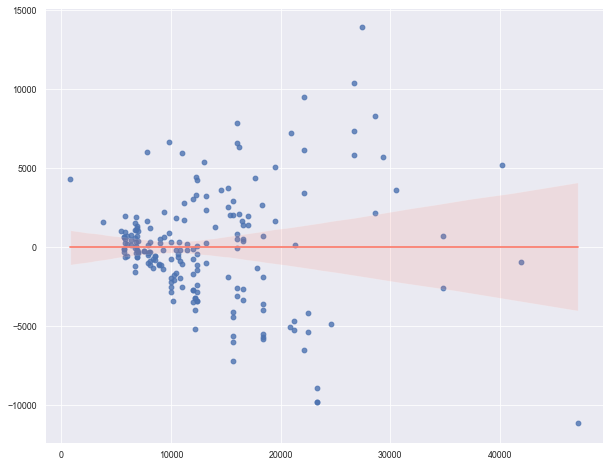

In [29]:
# Scatterplot + regression line of the residuals
sns.regplot(x=predicted, y=residuals, line_kws={'color':'salmon'});

As expected regression line of the risiduals is constant with y = 0. However, we can see an increasing variance as the values increase. Hence, the visual evidence in this case is not enough to draw conclusions.

<AxesSubplot:ylabel='Count'>

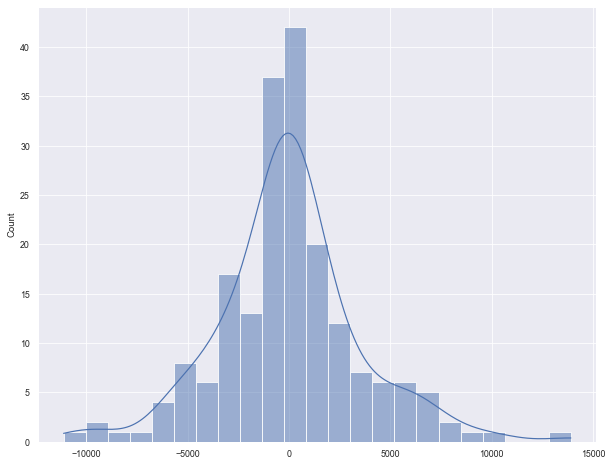

In [30]:
# histogram
sns.histplot(residuals, kde=True)

the best way to check the normality of the residuals is the qqplot

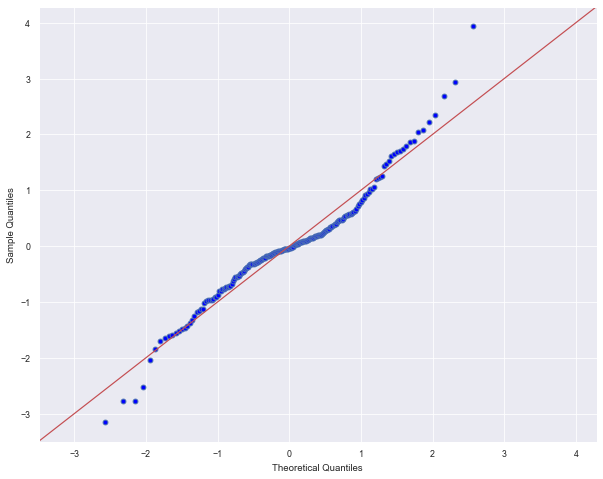

In [31]:
g = qqplot(residuals, fit=True, line='45')

The residuals distribution plot shows that the distribution is approximately bell-shaped, so based on the plot only we can say that the normality assumption is held. QQ-plot shows that the there are several outliers, but overall the dots are along the line.

### Diagnostic Tests for LINE Assumptions

In [32]:
#Linearity 
#The null hypothesis assumes that the regression is correctly modelled as linear
rnames = ["fstat", "p-value"]
rainbow = linear_rainbow(res)
print(list(zip(rnames, rainbow)))

[('fstat', 1.006919591417233), ('p-value', 0.48739625675795206)]


Linearity assumption is held, since we have a large p-value.

In [34]:
#Breusch-Pagan test for homoscedasticity
#The null hypothesis assumes homoskedasticity
bnames = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
breush = het_breuschpagan(residuals, res.model.exog)
print(list(zip(bnames, breush)))

[('Lagrange multiplier statistic', 63.4809339060186), ('p-value', 1.05983589170256e-13), ('f-value', 30.87807036206706), ('f p-value', 2.72501030765057e-16)]


In [ ]:
#Shapiro-Wilk normality test. 
#The null-hypothesis of this test is that the data was drawn from a normal distribution
snames = ['The test statistic', 'p-value']
shapiro = shapiro(residuals)
print(list(zip(snames, shapiro)))

[('The test statistic', 0.9631666541099548), ('p-value', 6.100742393755354e-05)]
